In [1]:

class Trained_Model:
  def __init__(self, idx, model, model_type, train_size, variables_used, \
               data_interval, date_range, device_location, training_time):
    self.idx = idx
    self.model = model
    self.model_type = model_type
    self.train_size = train_size
    self.var_used = variables_used
    self.interval = data_interval
    self.date_range = date_range
    self.dev_loc = device_location
    self.train_time = training_time

  def getFileDescription(self):
    return self.model_type + '_' + self.dev_loc + '_' + self.interval + '_' + self.date_range + '_' + str(self.train_size)

  def getCsvDict(self):
    return {"Index":self.idx, "Model Type":self.model_type, "Device Location":self.dev_loc, \
            "Data Interval":self.interval, "Date Range":self.date_range, "Training Size":self.train_size, \
            "Variables Used":self.var_used, "Training Time":self.train_time}
  
  def getCsvRow(self):
    return [self.idx, self.model_type, self.dev_loc, self.interval, \
            self.date_range, self.train_size, self.var_used, self.train_time]

In [2]:
import pickle

def load_model(model_idx):
  filename = "G:/My Drive/Air_Pollution_Models/" + str(model_idx) + ".obj"
  fileObj = open(filename, 'rb')
  trained_model = pickle.load(fileObj)
  fileObj.close()

  return trained_model

In [3]:
import pandas as pd
import pickle
#load dfs
with open("G:\My Drive\Air_Pollution_Data\dataframes\Y&E_dict.pickle", 'rb') as handle:
  dfs = pickle.load(handle) # dfs = {Y&E_60m: {July-Oct: df, Oct-Jan: df}, ...}


def get_pred_df_dict(trained_model):
  min_interval = int(trained_model.interval[:-1]) # i.e. covert "1m" to 1 int
  n_day_forecast = int(1440 / min_interval)
  print(n_day_forecast)
  n_week_forecast = int(n_day_forecast*7)
  n_2week_forecast = int(n_week_forecast*2)
  #n_month_forecast = int(n_2week_forecast*2)

  

  loc_interval = trained_model.dev_loc + "_" + trained_model.interval
  train_end_time = dfs[loc_interval][trained_model.date_range].index[trained_model.train_size]
  print(train_end_time)
  valid_df = dfs[loc_interval][trained_model.date_range].loc[train_end_time:] # get df used to train model and split it after the train size
  print(trained_model.model.data.row_labels)

  forecasts_dict = {}
  #predict_day = trained_model.model.get_prediction(start=train_end_time, end=valid_df.index[n_day_forecast - 1])
  day_results = trained_model.model.get_forecast(n_day_forecast, alpha = .05)
  week_results = trained_model.model.get_forecast(n_week_forecast, alpha = .05)
  week2_results = trained_model.model.get_forecast(n_2week_forecast, alpha = .05)

  predictions_day=pd.DataFrame(day_results.predicted_mean.add_suffix('_Prediction')).set_index(valid_df.iloc[:n_day_forecast].index)
  predictions_week=pd.DataFrame(week_results.predicted_mean.add_suffix('_Prediction')).set_index(valid_df.iloc[:n_week_forecast].index)
  predictions_2week=pd.DataFrame(week2_results.predicted_mean.add_suffix('_Prediction')).set_index(valid_df.iloc[:n_2week_forecast].index)

  ci_day = day_results.conf_int().set_index(valid_df.iloc[:n_day_forecast].index)
  ci_week = week_results.conf_int().set_index(valid_df.iloc[:n_week_forecast].index)
  ci_2week = week2_results.conf_int().set_index(valid_df.iloc[:n_2week_forecast].index)

  ci_dict = {"day": ci_day, "week": ci_week, "2_weeks": ci_2week}

  valid_vs_pred_day_df = pd.concat([valid_df.iloc[:n_day_forecast], predictions_day], axis=1)
  valid_vs_pred_week_df = pd.concat([valid_df.iloc[:n_week_forecast], predictions_week], axis=1)
  valid_vs_pred_2week_df = pd.concat([valid_df.iloc[:n_2week_forecast], predictions_2week], axis=1)

  return {"day": valid_vs_pred_day_df, "week": valid_vs_pred_week_df, "2_weeks": valid_vs_pred_2week_df}, ci_dict



In [4]:
from statsmodels.tsa.stattools import acf
import numpy as np

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [5]:
pred_columns = ["PM1", "PM2", "PM10", "CO", "CO2", "O3", "NO", "NO2"]
metric_columns=["mape", "me", "mae", "mpe", "rmse", "corr", "minmax"]
def adjust(val, length= 6): 
  return str(val).ljust(length)


def get_metrics_df(pred_df_dict):
    metrics_df = pd.DataFrame()

    col_index = pd.MultiIndex.from_product([pred_columns, metric_columns], names=["pred_cols", "metric_cols"])
    metrics_df = pd.DataFrame(index=pred_df_dict.keys(), columns=col_index)
    for pred_range, pred_df in pred_df_dict.items():
        for col in pred_columns:
            print('\nForecast accuracy of ' + col)
            accuracy_prod = forecast_accuracy(pred_df[col + '_Prediction'].values, pred_df[col])
            for k, v in accuracy_prod.items():
                print(adjust(k), ': ', round(v, 4))
                metrics_df.at[pred_range, (col, k)] = round(v, 4)

    return metrics_df


In [6]:
import matplotlib.pyplot as plt 

def plot_forecast(pred_df_dict, ci_dict, model_title, run_id):
  pred_columns = ["PM1", "PM2", "PM10", "CO", "CO2", "O3", "NO", "NO2"]
  fig, axes = plt.subplots(len(pred_columns), 4, figsize=(36, 70))
  i = 0
  for column in pred_columns:
    pred_df_dict["day"].plot(y=[column, column + "_Prediction"], ax=axes[i,0], title=model_title + " " + column + " 1 Day Forecast")
    axes[i,0].fill_between(ci_dict["day"].index, ci_dict["day"]["lower " + column], ci_dict["day"]["upper " + column], color='k', alpha=.25)
    pred_df_dict["week"].plot(y=[column, column + "_Prediction"],ax=axes[i,1], title=model_title + " " + column + " 1 Week Forecast")
    axes[i,1].fill_between(ci_dict["week"].index, ci_dict["week"]["lower " + column], ci_dict["week"]["upper " + column], color='k', alpha=.25)
    pred_df_dict["2_weeks"].plot(y=[column, column + "_Prediction"],ax=axes[i,2], title=model_title + " " + column + " 2 Week Forecast")
    axes[i,2].fill_between(ci_dict["2_weeks"].index, ci_dict["2_weeks"]["lower " + column], ci_dict["2_weeks"]["upper " + column], color='k', alpha=.25)
    pred_df_dict["month"].plot(y=[column, column + "_Prediction"],ax=axes[i,3], title=model_title + " " + column + " 1 Month Forecast")
    axes[i,3].fill_between(ci_dict["month"].index, ci_dict["month"]["lower " + column], ci_dict["month"]["upper " + column], color='k', alpha=.25)

    i = i + 1
    
  plt.savefig('/content/drive/MyDrive/Air_Pollution_Prediction_Figures/{}_run.png'.format(run_id))

In [7]:
import matplotlib.pyplot as plt
pred_columns = ["PM1", "PM2", "PM10", "CO", "CO2", "O3", "NO", "NO2"]

def make_metrics_figure(metrics_df, model_id, model_title):
    metrics = ["mape", "me", "mae", "mpe", "rmse", "corr", "minmax"]
    num_metrics = len(metrics)
    num_cols = len(pred_columns)
    
    fig, axs = plt.subplots(nrows=num_cols, ncols=num_metrics, figsize=(8*num_metrics, 8*num_cols))  # create subplots for each metric
    
    for i, pred_col in enumerate(pred_columns):
        for j, metric in enumerate(metrics):
            metrics_df[(pred_col, metric)].plot.bar(ax=axs[i,j])
            axs[i,j].set_title(metric + " of " + pred_col)  # set the title of the subplot to the metric name
            axs[i,j].set_ylabel(metric)  # set the y-axis label
            axs[i,j].set_xlabel("Forecast Length")  # set the x-axis label

    plt.suptitle("Performance metrics for " + model_title, fontsize=36)
    plt.tight_layout()  # adjust subplot spacing
    plt.subplots_adjust(top=0.95)
    plt.savefig('/content/drive/MyDrive/Air_Pollution_Prediction_Figures/{}_metrics.png'.format(model_id))
    plt.show()  # display the plot



24
2022-09-02 22:00:00-04:00
DatetimeIndex(['2022-07-23 01:00:00-04:00', '2022-07-23 02:00:00-04:00',
               '2022-07-23 03:00:00-04:00', '2022-07-23 04:00:00-04:00',
               '2022-07-23 05:00:00-04:00', '2022-07-23 06:00:00-04:00',
               '2022-07-23 07:00:00-04:00', '2022-07-23 08:00:00-04:00',
               '2022-07-23 09:00:00-04:00', '2022-07-23 10:00:00-04:00',
               ...
               '2022-09-02 12:00:00-04:00', '2022-09-02 13:00:00-04:00',
               '2022-09-02 14:00:00-04:00', '2022-09-02 15:00:00-04:00',
               '2022-09-02 16:00:00-04:00', '2022-09-02 17:00:00-04:00',
               '2022-09-02 18:00:00-04:00', '2022-09-02 19:00:00-04:00',
               '2022-09-02 20:00:00-04:00', '2022-09-02 21:00:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='Time', length=1000, freq=None)


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


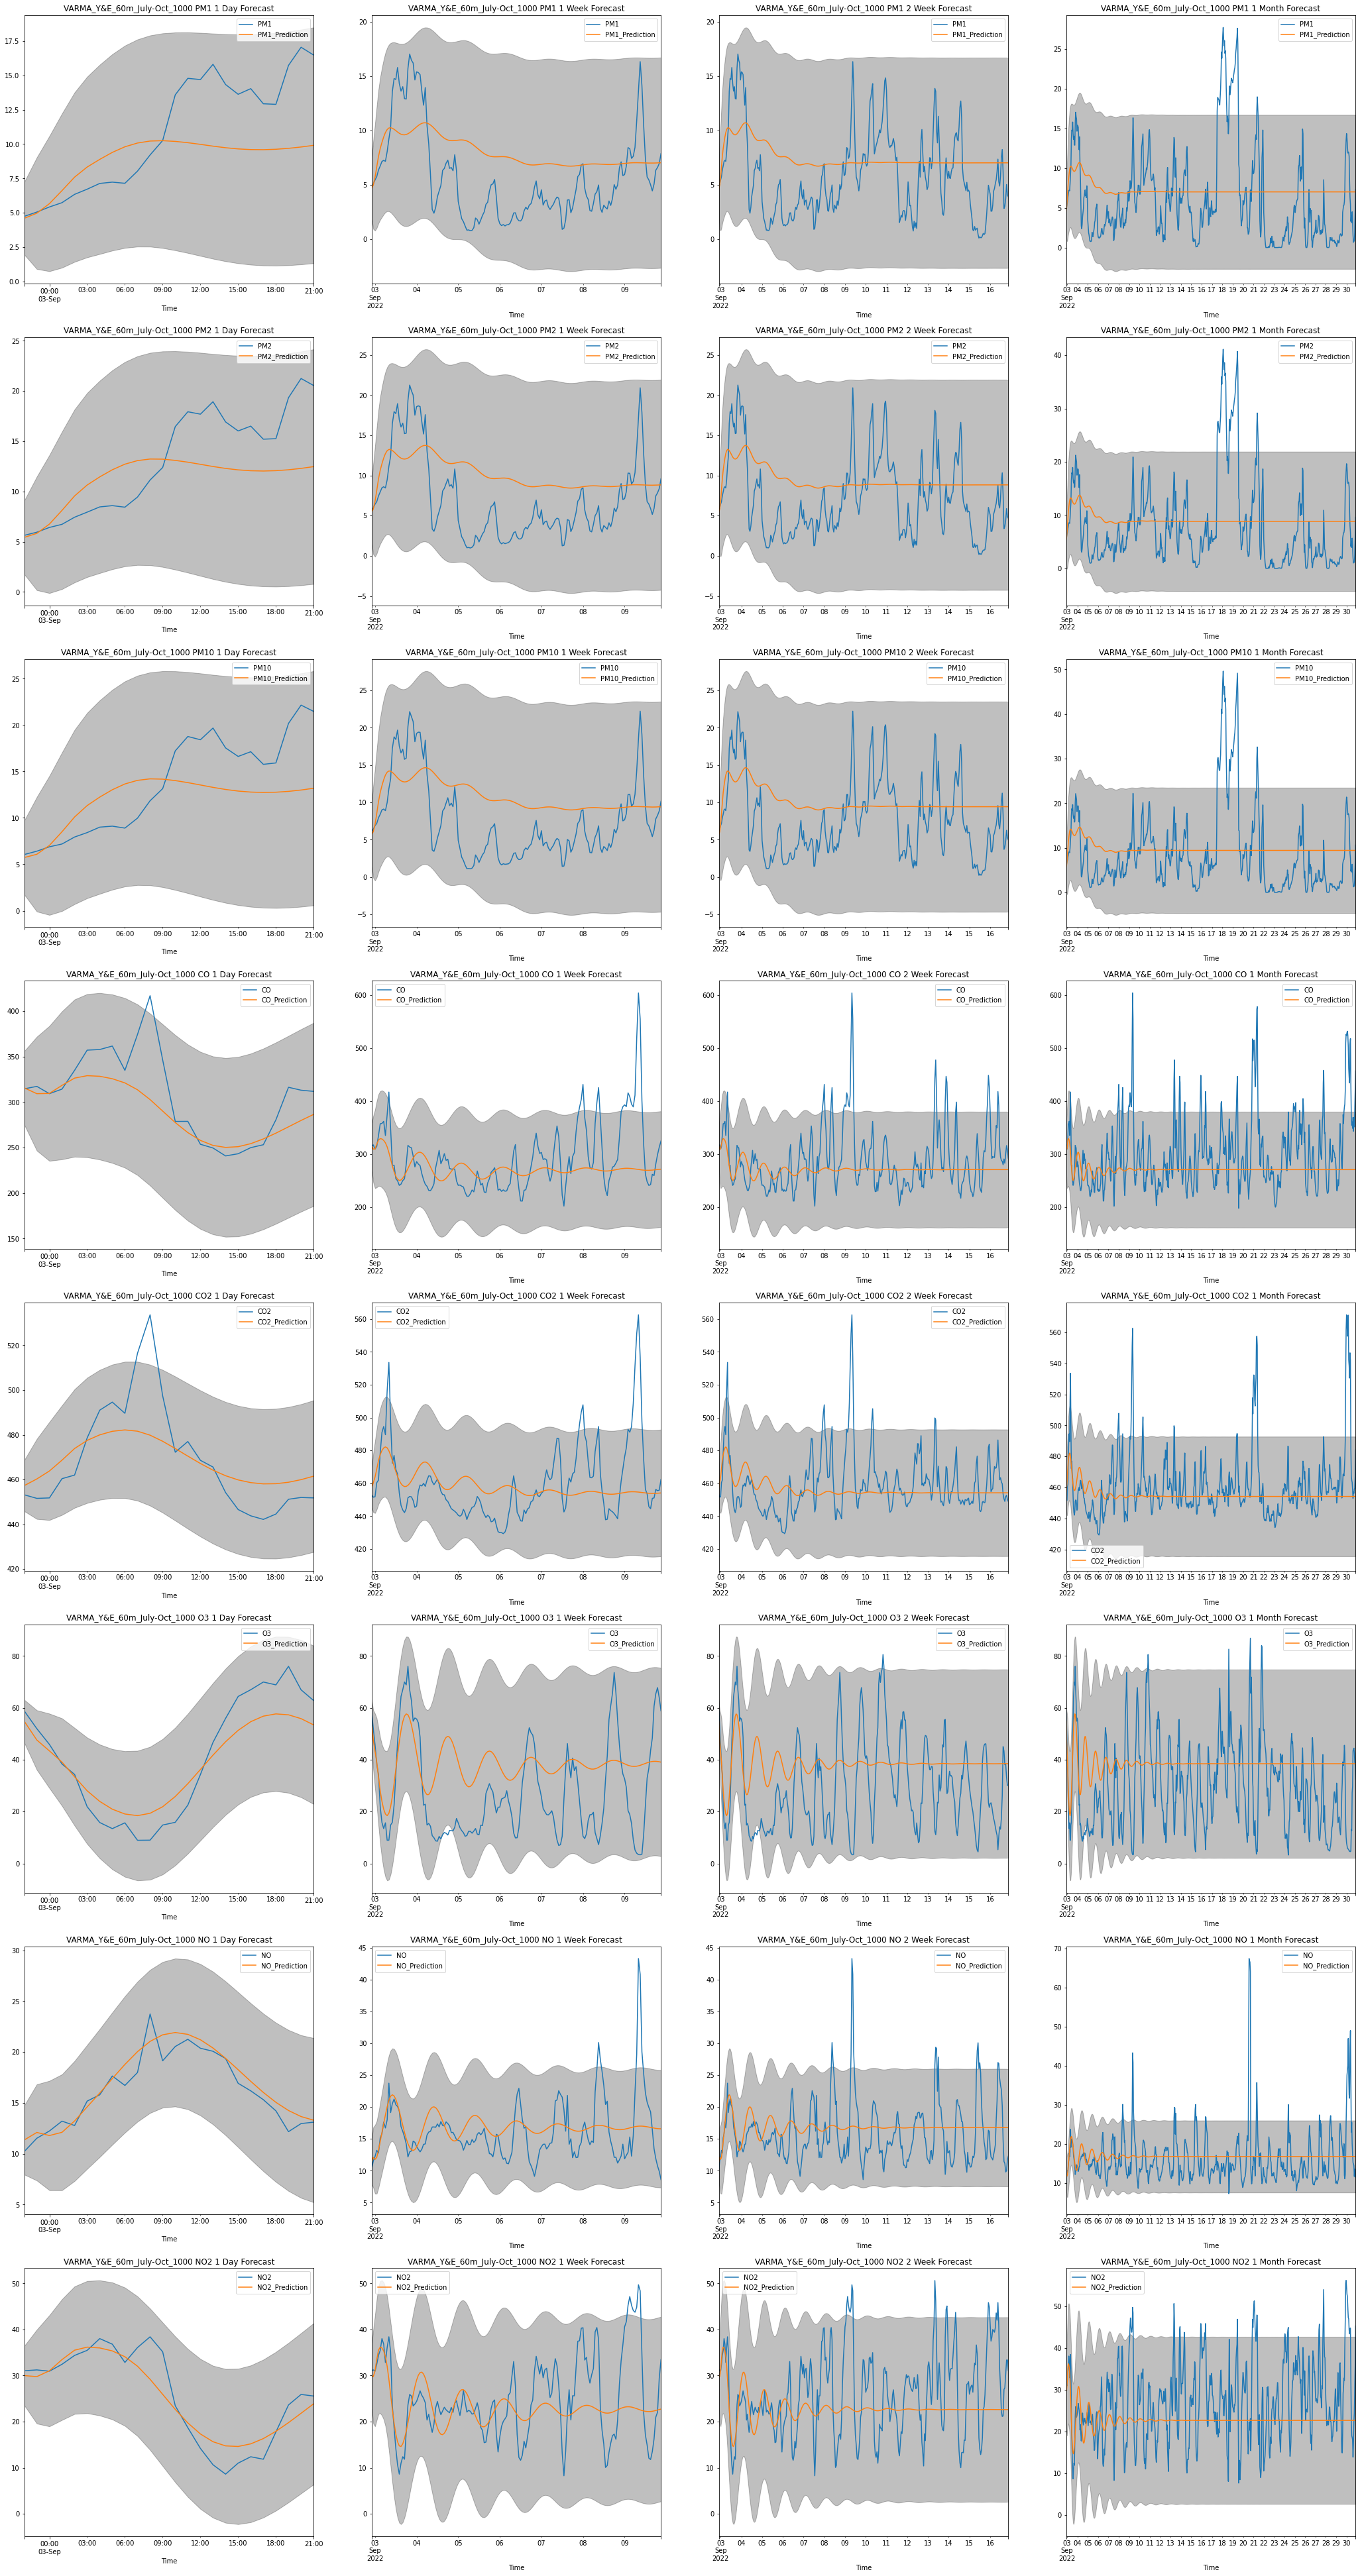

In [ ]:
# plot forecasts for models 1-6
MODEL_IDXS = [17]
for i in MODEL_IDXS:
  trained_model = load_model(i)
  pred_df_dict, ci_dict = get_pred_df_dict(trained_model)
  plot_forecast(pred_df_dict, ci_dict, trained_model.getFileDescription(), str(trained_model.idx))

24
2022-09-02 22:00:00-04:00
DatetimeIndex(['2022-07-23 01:00:00-04:00', '2022-07-23 02:00:00-04:00',
               '2022-07-23 03:00:00-04:00', '2022-07-23 04:00:00-04:00',
               '2022-07-23 05:00:00-04:00', '2022-07-23 06:00:00-04:00',
               '2022-07-23 07:00:00-04:00', '2022-07-23 08:00:00-04:00',
               '2022-07-23 09:00:00-04:00', '2022-07-23 10:00:00-04:00',
               ...
               '2022-09-02 12:00:00-04:00', '2022-09-02 13:00:00-04:00',
               '2022-09-02 14:00:00-04:00', '2022-09-02 15:00:00-04:00',
               '2022-09-02 16:00:00-04:00', '2022-09-02 17:00:00-04:00',
               '2022-09-02 18:00:00-04:00', '2022-09-02 19:00:00-04:00',
               '2022-09-02 20:00:00-04:00', '2022-09-02 21:00:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='Time', length=1000, freq=None)


C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



Forecast accuracy of PM1
mape   :  0.2447
me     :  -1.8666
mae    :  3.0003
mpe    :  -0.0851
rmse   :  3.6868
corr   :  0.7035
minmax :  0.2288

Forecast accuracy of PM2
mape   :  0.2644
me     :  -1.6541
mae    :  3.6488
mpe    :  -0.0313
rmse   :  4.3213
corr   :  0.6563
minmax :  0.2347

Forecast accuracy of PM10
mape   :  0.261
me     :  -1.5694
mae    :  3.7288
mpe    :  -0.0249
rmse   :  4.3977
corr   :  0.6419
minmax :  0.23

Forecast accuracy of CO
mape   :  0.064
me     :  -18.5183
mae    :  21.8885
mpe    :  -0.0507
rmse   :  33.7757
corr   :  0.8178
minmax :  0.0638

Forecast accuracy of CO2
mape   :  0.025
me     :  -0.5795
mae    :  11.9866
mpe    :  0.0004
rmse   :  16.4052
corr   :  0.8855
minmax :  0.0246

Forecast accuracy of O3
mape   :  0.297
me     :  -1.7356
mae    :  7.8147
mpe    :  0.1472
rmse   :  8.942
corr   :  0.9901
minmax :  0.208

Forecast accuracy of NO
mape   :  0.0622
me     :  0.5735
mae    :  0.9957
mpe    :  0.0384
rmse   :  1.2519
corr   :  0.94

C:\Users\Markus\AppData\Local\Temp\ipykernel_15300\1211373270.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\Markus\AppData\Local\Temp\ipykernel_15300\1211373270.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


FileNotFoundError: ignored

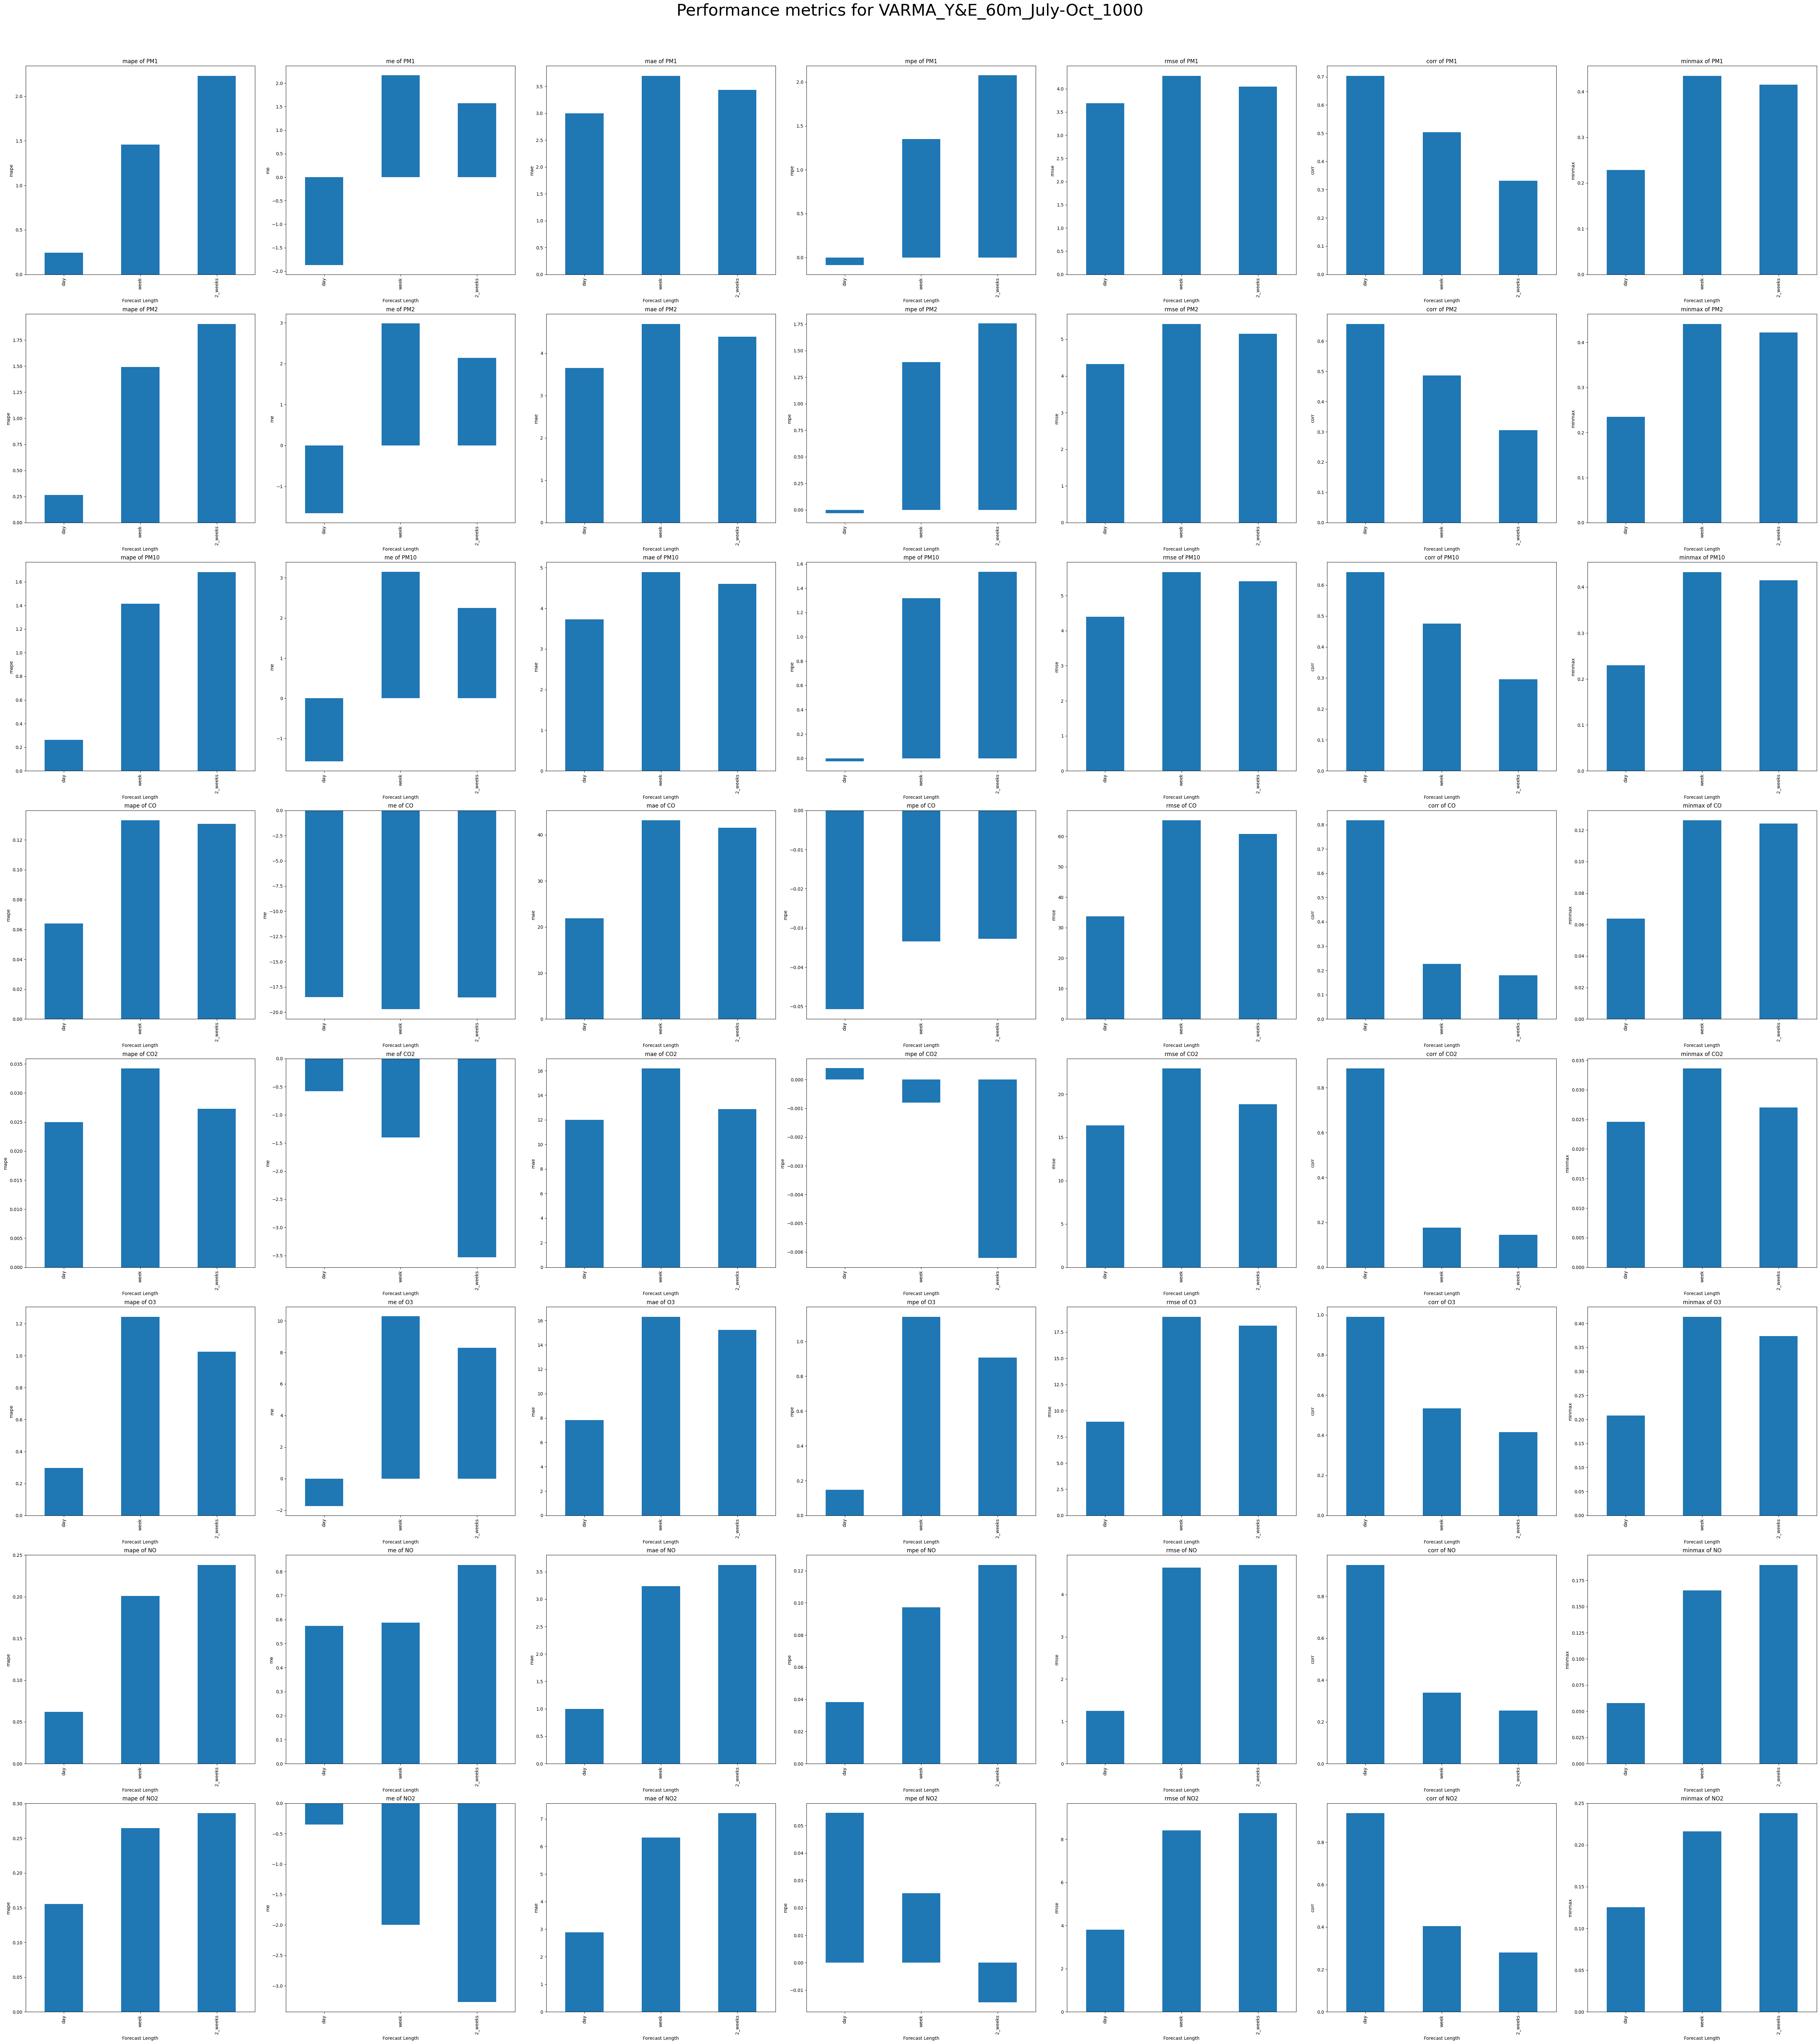

In [ ]:
# plot metrics for models 1-6
MODEL_IDXS = [17]
for i in MODEL_IDXS:
  trained_model = load_model(i)
  pred_df_dict, ci_dict = get_pred_df_dict(trained_model)
  metrics_df = get_metrics_df(pred_df_dict)
  make_metrics_figure(metrics_df, str(trained_model.idx), trained_model.getFileDescription())

In [ ]:
def compare_rmse_multiple_models(model_ids, model_titles, figure_title, testName):
  metric_dfs = []
  for i, model_id in enumerate(model_ids):
    trained_model = load_model(model_id)
    pred_df_dict, _ = get_pred_df_dict(trained_model)
    metric_df = get_metrics_df(pred_df_dict)
    metric_df = metric_df.loc[:, (slice(None), 'rmse')] # keep only rmse columns
    metric_df["Average_RMSE"] = metric_df.mean(axis=1)
    metric_df = metric_df.add_suffix(' ' + model_titles[i])
    print(metric_df.columns)
    metric_dfs.append(metric_df)

  combined_metrics = pd.concat(metric_dfs, axis=1)

  pred_columns = ["PM1", "PM2", "PM10", "CO", "CO2", "O3", "NO", "NO2"]
  num_cols = len(pred_columns)
  fig, axs = plt.subplots(nrows=num_cols, figsize=(10, 8*num_cols))  # create subplots for each metric

  for i, pred_col in enumerate(pred_columns):
    cols = []
    for title in model_titles:
      cols.append((pred_col + ' ' + title, 'rmse ' + title))
    print(cols)
    combined_metrics[cols].plot.bar(ax=axs[i])
    axs[i].set_title(pred_col + ' ' + figure_title)  # set the title of the subplot to the metric name
    axs[i].set_ylabel(pred_col)  # set the y-axis label
    axs[i].set_xlabel("Forecast Length")  # set the x-axis label
    axs[i].legend(model_titles)

  #plt.suptitle("Performance metrics for " + model_title, fontsize=36)
  plt.tight_layout()  # adjust subplot spacing
  #plt.subplots_adjust(top=0.95)
  plt.savefig('/content/drive/MyDrive/Air_Pollution_Prediction_Figures/{}_rmse_comp.png'.format(testName))
  plt.show()  # display the plot

  #save average rmse as separate graph
  avg_cols = []
  for title in model_titles:
    avg_cols.append("Average_RMSE " + title)
  fig, ax = plt.subplots()
  combined_metrics[avg_cols].plot.bar(figsize=(10, 8), title="Average " + figure_title, ax=ax)
  ax.legend(model_titles)
  ax.set_xlabel("Forecast Length")
  ax.set_ylabel("RMSE")
  plt.savefig('/content/drive/MyDrive/Air_Pollution_Prediction_Figures/{}_rmse_avg.png'.format(testName))

  





24
2022-10-25 07:00:00-04:00
DatetimeIndex(['2022-10-04 11:00:00-04:00', '2022-10-04 12:00:00-04:00',
               '2022-10-04 13:00:00-04:00', '2022-10-04 14:00:00-04:00',
               '2022-10-04 15:00:00-04:00', '2022-10-04 16:00:00-04:00',
               '2022-10-04 17:00:00-04:00', '2022-10-04 18:00:00-04:00',
               '2022-10-04 19:00:00-04:00', '2022-10-04 20:00:00-04:00',
               ...
               '2022-10-24 21:00:00-04:00', '2022-10-24 22:00:00-04:00',
               '2022-10-24 23:00:00-04:00', '2022-10-25 00:00:00-04:00',
               '2022-10-25 01:00:00-04:00', '2022-10-25 02:00:00-04:00',
               '2022-10-25 03:00:00-04:00', '2022-10-25 04:00:00-04:00',
               '2022-10-25 05:00:00-04:00', '2022-10-25 06:00:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='Time', length=500, freq=None)

Forecast accuracy of PM1
mape   :  0.2305
me     :  -0.1414
mae    :  1.631
mpe    :  0.0892
rmse   :  2.0806
corr   :  0.9248
minmax 

<ipython-input-27-b7ae7c333cce>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-27-b7ae7c333cce>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


mape   :  inf
me     :  -6.8946
mae    :  10.9986
mpe    :  inf
rmse   :  14.2013
corr   :  -0.0066
minmax :  0.6491

Forecast accuracy of PM10
mape   :  inf
me     :  -10.7231
mae    :  16.1401
mpe    :  inf
rmse   :  21.6722
corr   :  -0.0192
minmax :  0.6513

Forecast accuracy of CO
mape   :  0.2203
me     :  -45.0065
mae    :  84.7236
mpe    :  -0.0557
rmse   :  114.3487
corr   :  -0.0975
minmax :  0.2008

Forecast accuracy of CO2
mape   :  0.0663
me     :  -30.0284
mae    :  35.013
mpe    :  -0.0553
rmse   :  48.9947
corr   :  0.0036
minmax :  0.0662

Forecast accuracy of O3
mape   :  2.7077
me     :  7.8435
mae    :  14.1349
mpe    :  2.5533
rmse   :  16.0273
corr   :  0.1794
minmax :  0.4889

Forecast accuracy of NO
mape   :  0.3064
me     :  -2.6836
mae    :  6.7666
mpe    :  0.0469
rmse   :  11.823
corr   :  0.1163
minmax :  0.2493

Forecast accuracy of NO2
mape   :  0.2866
me     :  -4.6058
mae    :  11.0603
mpe    :  -0.0105
rmse   :  13.3178
corr   :  0.136
minmax :  0.2379

<ipython-input-27-b7ae7c333cce>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-27-b7ae7c333cce>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


-2.3945
mae    :  3.432
mpe    :  inf
rmse   :  4.6128
corr   :  -0.1923
minmax :  0.4924

Forecast accuracy of PM2
mape   :  inf
me     :  -3.3064
mae    :  4.5945
mpe    :  inf
rmse   :  6.387
corr   :  -0.1987
minmax :  0.4994

Forecast accuracy of PM10
mape   :  inf
me     :  -4.4007
mae    :  6.1005
mpe    :  inf
rmse   :  8.5317
corr   :  -0.1999
minmax :  0.4949

Forecast accuracy of CO
mape   :  0.2136
me     :  36.7281
mae    :  59.8671
mpe    :  0.1602
rmse   :  72.0521
corr   :  -0.0832
minmax :  0.1671

Forecast accuracy of CO2
mape   :  0.032
me     :  2.4755
mae    :  15.1575
mpe    :  0.0072
rmse   :  20.9075
corr   :  -0.0443
minmax :  0.0313

Forecast accuracy of O3
mape   :  2.2514
me     :  3.9733
mae    :  15.2214
mpe    :  2.0254
rmse   :  17.7002
corr   :  0.1928
minmax :  0.4479

Forecast accuracy of NO
mape   :  0.3222
me     :  1.1354
mae    :  5.0079
mpe    :  0.1925
rmse   :  6.7929
corr   :  -0.0634
minmax :  0.2341

Forecast accuracy of NO2
mape   :  0.2287

<ipython-input-27-b7ae7c333cce>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-27-b7ae7c333cce>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


mape   :  0.3362
me     :  -13.094
mae    :  14.2229
mpe    :  -0.2682
rmse   :  18.8482
corr   :  0.117
minmax :  0.3266

Forecast accuracy of PM1
mape   :  inf
me     :  -2.6571
mae    :  3.0904
mpe    :  inf
rmse   :  4.1774
corr   :  -0.0438
minmax :  0.5993

Forecast accuracy of PM2
mape   :  inf
me     :  -3.2611
mae    :  3.8408
mpe    :  inf
rmse   :  5.3486
corr   :  -0.0422
minmax :  0.5762

Forecast accuracy of PM10
mape   :  inf
me     :  -4.2161
mae    :  5.0292
mpe    :  inf
rmse   :  7.0023
corr   :  -0.0391
minmax :  0.5623

Forecast accuracy of CO
mape   :  0.3306
me     :  64.2671
mae    :  92.4558
mpe    :  0.2773
rmse   :  106.2338
corr   :  0.1278
minmax :  0.2347

Forecast accuracy of CO2
mape   :  0.0279
me     :  -7.7139
mae    :  13.4868
mpe    :  -0.0149
rmse   :  21.7366
corr   :  0.0264
minmax :  0.0277

Forecast accuracy of O3
mape   :  1.9481
me     :  8.0831
mae    :  15.4089
mpe    :  1.8079
rmse   :  18.2432
corr   :  0.0229
minmax :  0.4123

Forecast a

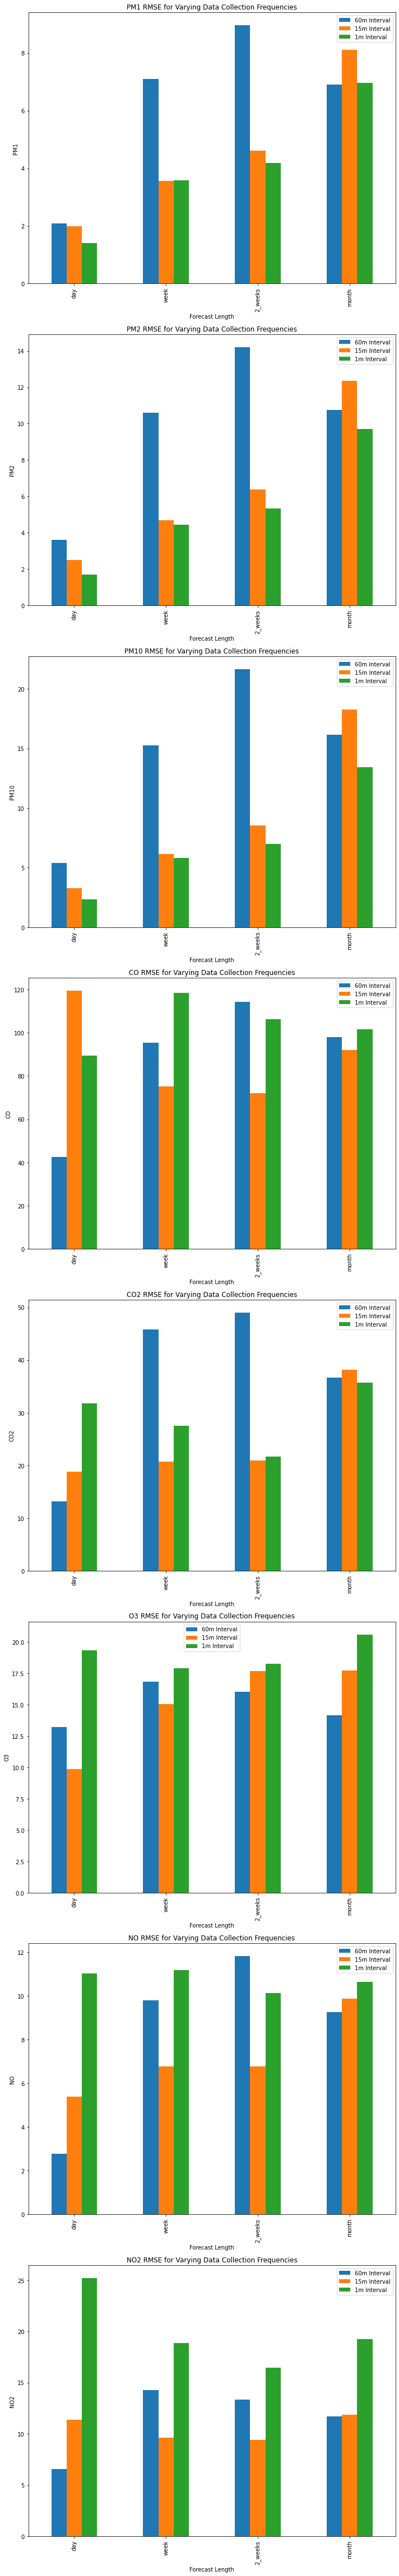

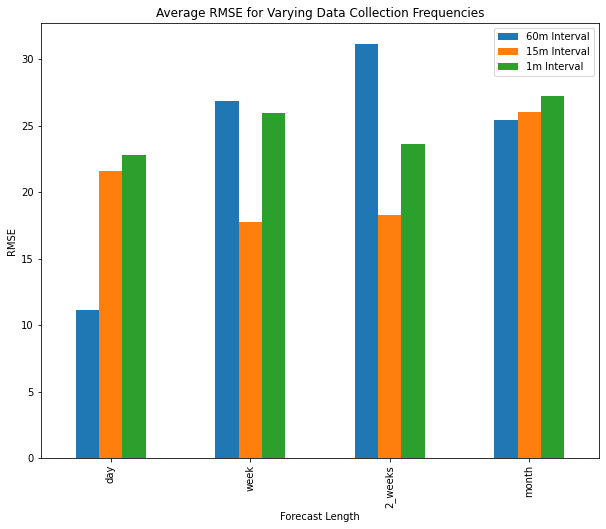

In [ ]:
# get rmse comparison between models
model_ids = [2, 4, 6]
model_titles = ["60m Interval", "15m Interval", "1m Interval"]
compare_rmse_multiple_models(model_ids, model_titles, "RMSE for Varying Data Collection Frequencies", "interval_var_oct_jan")

In [10]:
def compare_mape_multiple_models(model_ids, model_titles, figure_title, testName):
  metric_dfs = []
  for i, model_id in enumerate(model_ids):
    trained_model = load_model(model_id)
    pred_df_dict, _ = get_pred_df_dict(trained_model)
    metric_df = get_metrics_df(pred_df_dict)
    metric_df = metric_df.loc[:, (slice(None), 'mape')] # keep only rmse columns
    metric_df["Average_MAPE"] = metric_df.mean(axis=1)
    metric_df = metric_df.add_suffix(' ' + model_titles[i])

    print(metric_df.columns)
    metric_dfs.append(metric_df)

  combined_metrics = pd.concat(metric_dfs, axis=1)

  pred_columns = ["PM1", "PM2", "PM10", "CO", "CO2", "O3", "NO", "NO2"]
  num_cols = len(pred_columns)
  fig, axs = plt.subplots(nrows=num_cols, figsize=(5, 4*num_cols))  # create subplots for each metric

  for i, pred_col in enumerate(pred_columns):
    cols = []
    for title in model_titles:
      cols.append((pred_col + ' ' + title, 'mape ' + title))
    print(cols)
    combined_metrics[cols].plot.bar(ax=axs[i])
    axs[i].set_title(pred_col + ' ' + figure_title, fontsize=16)  # set the title of the subplot to the metric name
    axs[i].set_ylabel("MAPE of " + pred_col, fontsize=12)  # set the y-axis label
    axs[i].set_xlabel("Forecast Length", fontsize=12)  # set the x-axis label
    axs[i].legend(model_titles, fontsize=10)

  plt.tight_layout()  # adjust subplot spacing
  plt.savefig('G:\My Drive\Air_Pollution_Prediction_Figures\{}_mape_comp.png'.format(testName))
  plt.show()  # display the plot

  #save average mape as separate graph
  avg_cols = []
  for title in model_titles:
    avg_cols.append("Average_MAPE " + title)
  fig, ax = plt.subplots()
  combined_metrics[avg_cols].plot.bar(figsize=(6, 4), ax=ax)
  ax.legend(model_titles, fontsize=10, title="Data Frequency")
  ax.set_title("Average " + figure_title, fontsize=16)  # set the title of the subplot to the metric name
  ax.set_xlabel("Forecast Length", fontsize=12)
  ax.set_ylabel("Mean Absolute Percentage Error (MAPE)", fontsize=12)
  plt.savefig('G:\My Drive\Air_Pollution_Prediction_Figures\{}_mape_avg.png'.format(testName))

24
2022-09-02 22:00:00-04:00
DatetimeIndex(['2022-07-23 01:00:00-04:00', '2022-07-23 02:00:00-04:00',
               '2022-07-23 03:00:00-04:00', '2022-07-23 04:00:00-04:00',
               '2022-07-23 05:00:00-04:00', '2022-07-23 06:00:00-04:00',
               '2022-07-23 07:00:00-04:00', '2022-07-23 08:00:00-04:00',
               '2022-07-23 09:00:00-04:00', '2022-07-23 10:00:00-04:00',
               ...
               '2022-09-02 12:00:00-04:00', '2022-09-02 13:00:00-04:00',
               '2022-09-02 14:00:00-04:00', '2022-09-02 15:00:00-04:00',
               '2022-09-02 16:00:00-04:00', '2022-09-02 17:00:00-04:00',
               '2022-09-02 18:00:00-04:00', '2022-09-02 19:00:00-04:00',
               '2022-09-02 20:00:00-04:00', '2022-09-02 21:00:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='Time', length=1000, freq=None)

Forecast accuracy of PM1
mape   :  0.2447
me     :  -1.8666
mae    :  3.0003
mpe    :  -0.0851
rmse   :  3.6868
corr   :  0.7035
minm

C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Markus\AppData\Local\Temp\ipykernel_24760\1211373270.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future versi

MultiIndex([(         'PM1 Best Model', 'mape Best Model'),
            (         'PM2 Best Model', 'mape Best Model'),
            (        'PM10 Best Model', 'mape Best Model'),
            (          'CO Best Model', 'mape Best Model'),
            (         'CO2 Best Model', 'mape Best Model'),
            (          'O3 Best Model', 'mape Best Model'),
            (          'NO Best Model', 'mape Best Model'),
            (         'NO2 Best Model', 'mape Best Model'),
            ('Average_MAPE Best Model',     ' Best Model')],
           names=['pred_cols', 'metric_cols'])
[('PM1 Best Model', 'mape Best Model')]
[('PM2 Best Model', 'mape Best Model')]
[('PM10 Best Model', 'mape Best Model')]
[('CO Best Model', 'mape Best Model')]
[('CO2 Best Model', 'mape Best Model')]
[('O3 Best Model', 'mape Best Model')]
[('NO Best Model', 'mape Best Model')]
[('NO2 Best Model', 'mape Best Model')]


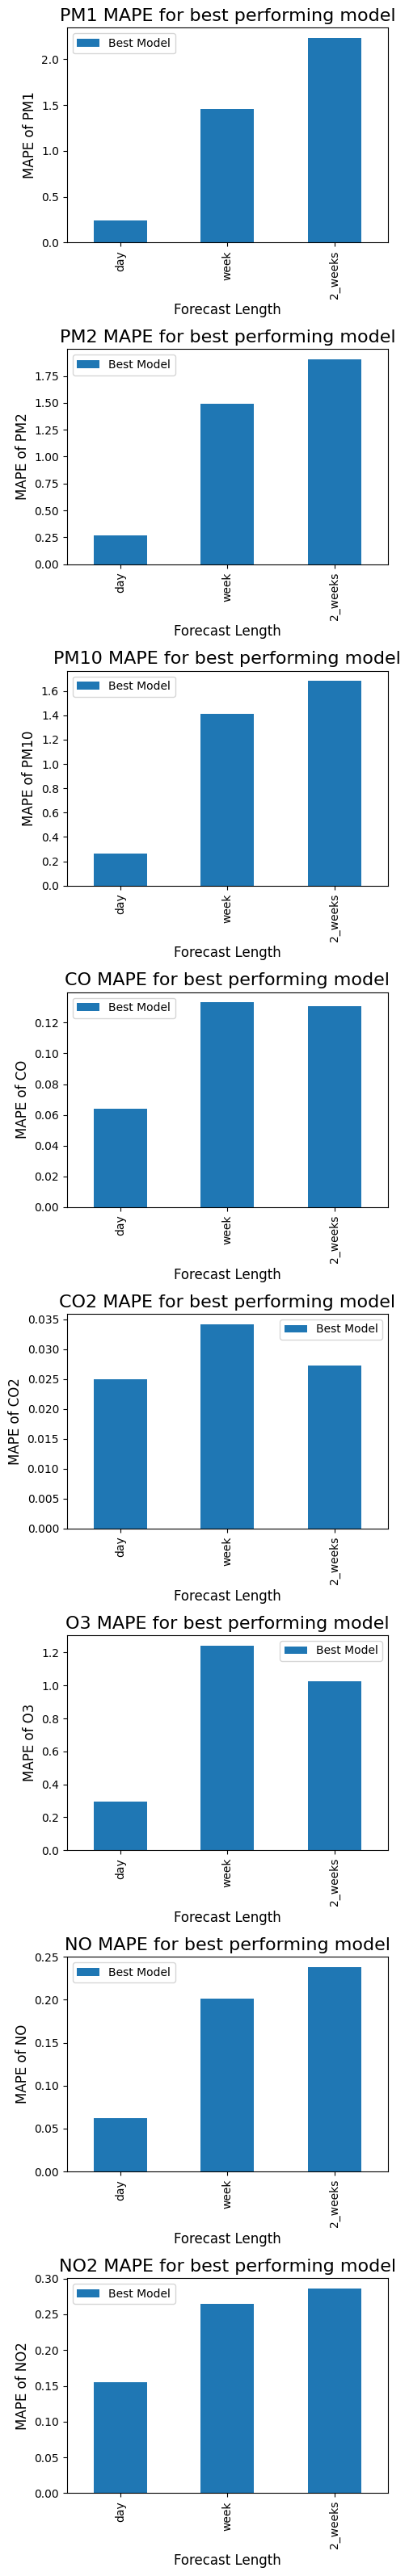

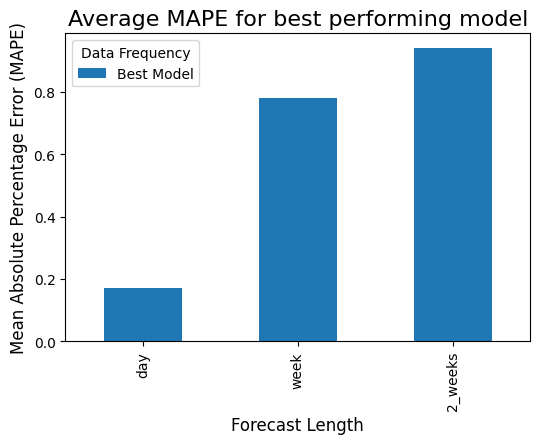

In [11]:
# get mape comparison between models
model_ids = [17]
model_titles = ["Best Model"]
compare_mape_multiple_models(model_ids, model_titles, "MAPE for best performing model", "VARMA_60_oct_jan_1000")

In [ ]:
def compare_mape_multiple_models_size(model_ids, model_titles, figure_title, testName):
  metric_dfs = []
  for i, model_id in enumerate(model_ids):
    trained_model = load_model(model_id)
    pred_df_dict, _ = get_pred_df_dict(trained_model)
    metric_df = get_metrics_df(pred_df_dict)
    metric_df = metric_df.loc[:, (slice(None), 'mape')] # keep only rmse columns
    metric_df["Average_MAPE"] = metric_df.mean(axis=1)
    metric_df = metric_df.add_suffix(' ' + model_titles[i])
    
    print(metric_df.columns)
    metric_dfs.append(metric_df)

  combined_metrics = pd.concat(metric_dfs, axis=1)
  combined_metrics = combined_metrics.loc["week"] #ONLY LOOK AT WEEK FORECAST
  pred_columns = ["PM1", "PM2", "PM10", "CO", "CO2", "O3", "NO", "NO2"]
  num_cols = len(pred_columns)
  fig, axs = plt.subplots(nrows=num_cols, figsize=(10, 8*num_cols))  # create subplots for each metric

  for i, pred_col in enumerate(pred_columns):
    cols = []
    for title in model_titles:
      cols.append((pred_col + ' ' + title, 'mape ' + title))
    print(cols)
    combined_metrics[cols].plot(ax=axs[i])
    axs[i].set_title(pred_col + ' ' + figure_title, fontsize=24)  # set the title of the subplot to the metric name
    axs[i].set_ylabel(pred_col + " MAPE", fontsize=18)  # set the y-axis label
    axs[i].set_xlabel("Training Size", fontsize=18)  # set the x-axis label
    #axs[i].legend(model_titles, fontsize=16)

  #plt.suptitle("Performance metrics for " + model_title, fontsize=36)
  plt.tight_layout()  # adjust subplot spacing
  #plt.subplots_adjust(top=0.95)
  plt.savefig('/content/drive/MyDrive/Air_Pollution_Prediction_Figures/{}_mape_comp.png'.format(testName))
  plt.show()  # display the plot

  #save average mape as separate graph
  avg_cols = []
  for title in model_titles:
    avg_cols.append("Average_MAPE " + title)
  fig, ax = plt.subplots()
  combined_metrics[avg_cols].plot(figsize=(10, 8), ax=ax)
  #ax.legend(model_titles, fontsize=16, title="Training Size")
  ax.set_title("Average " + figure_title, fontsize=24)  # set the title of the subplot to the metric name
  ax.set_xlabel("Training Size", fontsize=18)
  ax.set_ylabel("Mean Absolute Percentage Error (MAPE)", fontsize=18)
  plt.savefig('/content/drive/MyDrive/Air_Pollution_Prediction_Figures/{}_mape_avg.png'.format(testName))

96
2022-07-24 01:15:00-04:00
DatetimeIndex(['2022-07-23 00:15:00-04:00', '2022-07-23 00:30:00-04:00',
               '2022-07-23 00:45:00-04:00', '2022-07-23 01:00:00-04:00',
               '2022-07-23 01:15:00-04:00', '2022-07-23 01:30:00-04:00',
               '2022-07-23 01:45:00-04:00', '2022-07-23 02:00:00-04:00',
               '2022-07-23 02:15:00-04:00', '2022-07-23 02:30:00-04:00',
               '2022-07-23 02:45:00-04:00', '2022-07-23 03:00:00-04:00',
               '2022-07-23 03:15:00-04:00', '2022-07-23 03:30:00-04:00',
               '2022-07-23 03:45:00-04:00', '2022-07-23 04:00:00-04:00',
               '2022-07-23 04:15:00-04:00', '2022-07-23 04:30:00-04:00',
               '2022-07-23 04:45:00-04:00', '2022-07-23 05:00:00-04:00',
               '2022-07-23 05:15:00-04:00', '2022-07-23 05:30:00-04:00',
               '2022-07-23 05:45:00-04:00', '2022-07-23 06:00:00-04:00',
               '2022-07-23 06:15:00-04:00', '2022-07-23 06:30:00-04:00',
               '2022-0

<ipython-input-5-b7ae7c333cce>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-5-b7ae7c333cce>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


mape   :  0.7147
me     :  -7.8297
mae    :  8.5028
mpe    :  -0.4906
rmse   :  10.8395
corr   :  -0.5032
minmax :  0.6691

Forecast accuracy of PM10
mape   :  0.7118
me     :  -8.2731
mae    :  9.005
mpe    :  -0.4887
rmse   :  11.4563
corr   :  -0.5117
minmax :  0.6663

Forecast accuracy of CO
mape   :  0.0968
me     :  8.4788
mae    :  24.5972
mpe    :  0.0435
rmse   :  29.1754
corr   :  0.1792
minmax :  0.0883

Forecast accuracy of CO2
mape   :  0.0141
me     :  -0.6806
mae    :  6.398
mpe    :  -0.0012
rmse   :  7.7255
corr   :  0.5785
minmax :  0.014

Forecast accuracy of O3
mape   :  0.2235
me     :  -12.3854
mae    :  12.9183
mpe    :  -0.2055
rmse   :  17.8144
corr   :  0.4984
minmax :  0.2224

Forecast accuracy of NO
mape   :  0.2062
me     :  0.726
mae    :  2.8299
mpe    :  0.1135
rmse   :  4.0046
corr   :  0.1593
minmax :  0.1385

Forecast accuracy of NO2
mape   :  0.3215
me     :  1.5368
mae    :  6.8162
mpe    :  0.186
rmse   :  8.8907
corr   :  0.1926
minmax :  0.216

F

<ipython-input-5-b7ae7c333cce>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-5-b7ae7c333cce>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


mape   :  inf
me     :  -4.7014
mae    :  6.0313
mpe    :  inf
rmse   :  8.2399
corr   :  0.3265
minmax :  0.5143

Forecast accuracy of CO
mape   :  0.1348
me     :  -12.5442
mae    :  36.5799
mpe    :  -0.0199
rmse   :  47.2683
corr   :  0.2333
minmax :  0.1255

Forecast accuracy of CO2
mape   :  0.0375
me     :  -13.8666
mae    :  17.5463
mpe    :  -0.0289
rmse   :  23.2282
corr   :  0.1237
minmax :  0.0374

Forecast accuracy of O3
mape   :  0.5377
me     :  1.4461
mae    :  13.9807
mpe    :  0.3227
rmse   :  16.5367
corr   :  0.2055
minmax :  0.2974

Forecast accuracy of NO
mape   :  0.2235
me     :  0.9106
mae    :  3.3253
mpe    :  0.1166
rmse   :  4.1183
corr   :  0.0801
minmax :  0.1746

Forecast accuracy of NO2
mape   :  0.548
me     :  0.4866
mae    :  7.8783
mpe    :  0.3239
rmse   :  9.3381
corr   :  0.2673
minmax :  0.2995
MultiIndex([(         'PM1 300', 'mape 300'),
            (         'PM2 300', 'mape 300'),
            (        'PM10 300', 'mape 300'),
            (  

<ipython-input-5-b7ae7c333cce>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-5-b7ae7c333cce>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


 inf
rmse   :  7.0375
corr   :  0.3066
minmax :  0.4774

Forecast accuracy of PM10
mape   :  inf
me     :  -0.7487
mae    :  5.2869
mpe    :  inf
rmse   :  7.2457
corr   :  -0.1532
minmax :  0.438

Forecast accuracy of CO
mape   :  0.1427
me     :  4.7792
mae    :  36.0668
mpe    :  0.0474
rmse   :  45.3522
corr   :  -0.0413
minmax :  0.1249

Forecast accuracy of CO2
mape   :  0.0351
me     :  -10.0426
mae    :  16.3886
mpe    :  -0.0205
rmse   :  21.2378
corr   :  -0.0581
minmax :  0.0349

Forecast accuracy of O3
mape   :  0.5948
me     :  0.9322
mae    :  14.3467
mpe    :  0.3661
rmse   :  17.239
corr   :  -0.0751
minmax :  0.3118

Forecast accuracy of NO
mape   :  0.2216
me     :  1.0084
mae    :  3.1986
mpe    :  0.1226
rmse   :  3.9815
corr   :  -0.0235
minmax :  0.1697

Forecast accuracy of NO2
mape   :  0.5795
me     :  1.66
mae    :  7.7649
mpe    :  0.3939
rmse   :  9.2893
corr   :  -0.0776
minmax :  0.2981
MultiIndex([(         'PM1 500', 'mape 500'),
            (         'P

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



Forecast accuracy of PM1
mape   :  4.9789
me     :  1.3452
mae    :  2.5445
mpe    :  4.6943
rmse   :  2.9311
corr   :  -0.3691
minmax :  0.5645

Forecast accuracy of PM2
mape   :  3.2573
me     :  1.5889
mae    :  3.0319
mpe    :  3.0026
rmse   :  3.507
corr   :  -0.3561
minmax :  0.5406

Forecast accuracy of PM10
mape   :  2.7526
me     :  1.6579
mae    :  3.1196
mpe    :  2.5174
rmse   :  3.6236
corr   :  -0.331
minmax :  0.5192

Forecast accuracy of CO
mape   :  0.0716
me     :  -8.8558
mae    :  20.5935
mpe    :  -0.0184
rmse   :  32.02
corr   :  0.8174
minmax :  0.0699

Forecast accuracy of CO2
mape   :  0.0168
me     :  -5.7158
mae    :  7.7132
mpe    :  -0.0122
rmse   :  11.5533
corr   :  0.776
minmax :  0.0168

Forecast accuracy of O3
mape   :  0.2691
me     :  3.6014
mae    :  5.6359
mpe    :  0.2223
rmse   :  7.9714
corr   :  0.8402
minmax :  0.1602

Forecast accuracy of NO
mape   :  0.1224
me     :  0.4955
mae    :  1.9215
mpe    :  0.0603
rmse   :  2.5267
corr   :  0.8167

<ipython-input-5-b7ae7c333cce>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-5-b7ae7c333cce>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


mape   :  0.6387
me     :  1.0392
mae    :  7.8567
mpe    :  0.4266
rmse   :  9.472
corr   :  0.2425
minmax :  0.309
MultiIndex([(         'PM1 1000', 'mape 1000'),
            (         'PM2 1000', 'mape 1000'),
            (        'PM10 1000', 'mape 1000'),
            (          'CO 1000', 'mape 1000'),
            (         'CO2 1000', 'mape 1000'),
            (          'O3 1000', 'mape 1000'),
            (          'NO 1000', 'mape 1000'),
            (         'NO2 1000', 'mape 1000'),
            ('Average_MAPE 1000',     ' 1000')],
           names=['pred_cols', 'metric_cols'])
[('PM1 100', 'mape 100'), ('PM1 300', 'mape 300'), ('PM1 500', 'mape 500'), ('PM1 1000', 'mape 1000')]
[('PM2 100', 'mape 100'), ('PM2 300', 'mape 300'), ('PM2 500', 'mape 500'), ('PM2 1000', 'mape 1000')]
[('PM10 100', 'mape 100'), ('PM10 300', 'mape 300'), ('PM10 500', 'mape 500'), ('PM10 1000', 'mape 1000')]
[('CO 100', 'mape 100'), ('CO 300', 'mape 300'), ('CO 500', 'mape 500'), ('CO 1000', 'mape

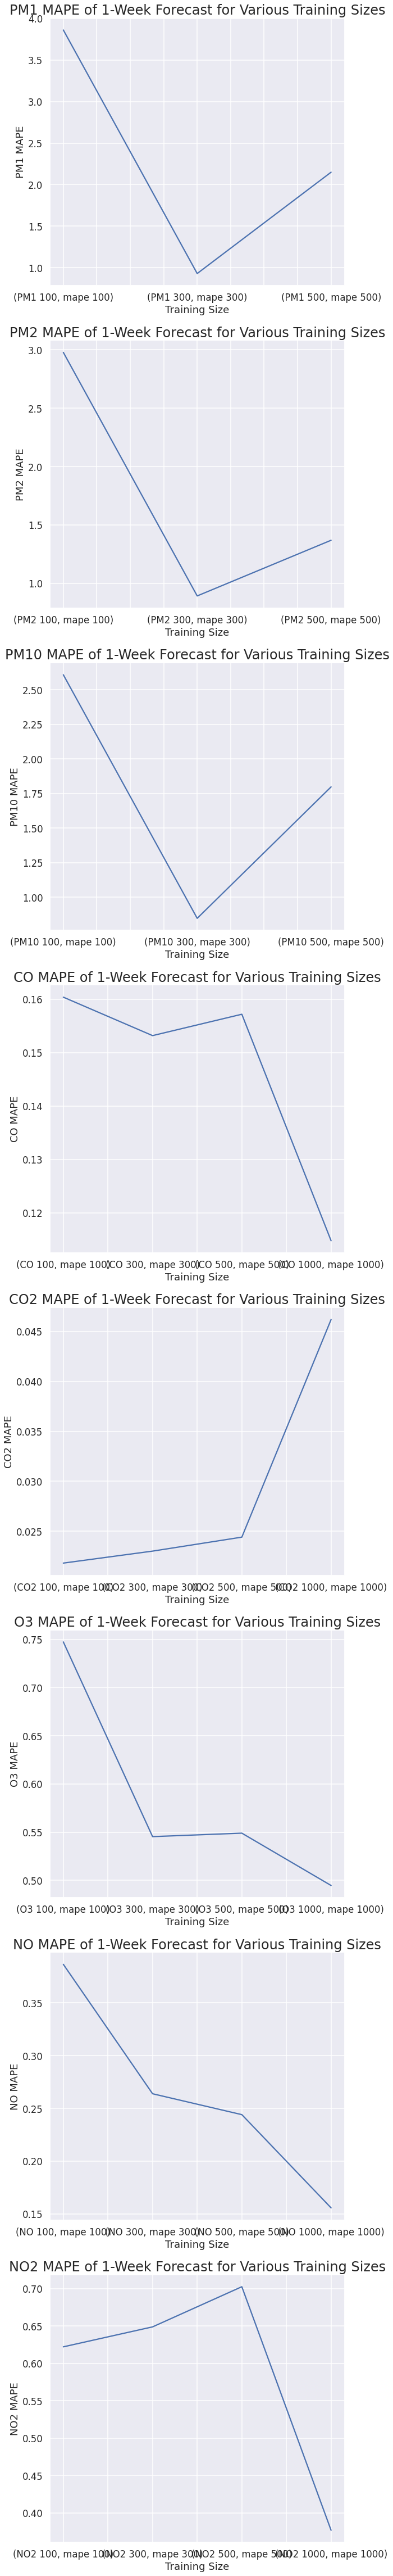

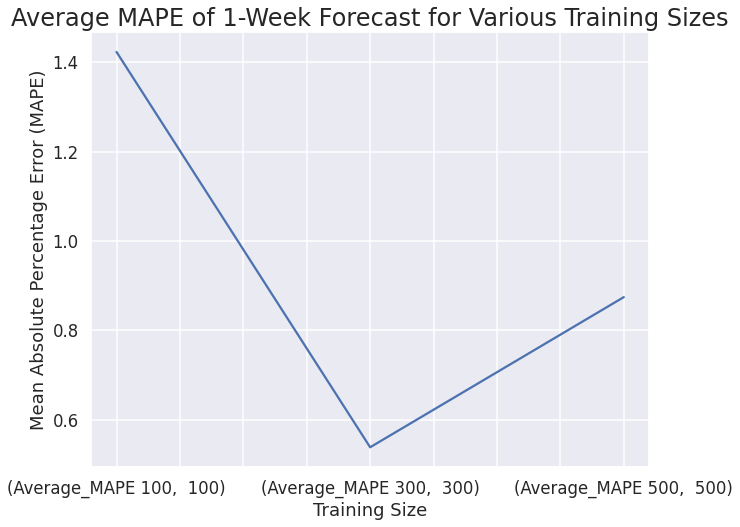

In [ ]:
# get mape comparison between models
model_ids = [17]
model_titles = ["Best Model"]
compare_mape_multiple_models_size(model_ids, model_titles, "MAPE for best performing model", "VARMA_60_oct_jan_1000")

In [ ]:
import seaborn as sns
def plot_training_time(model_ids):
  sizes = []
  times = []
  sns.set_context("talk")
  #sns.set_theme(style="darkgrid")
  for i, model_id in enumerate(model_ids):
    trained_model = load_model(model_id)
    sizes.append(trained_model.train_size)
    times.append(trained_model.train_time)
  
  sizes.append(3000)
  times.append(10510)
  df = pd.DataFrame({'Training Time (s)': times, 'Training Size': sizes})
  df = df.append({'Training Time (s)': 10510, 'Training Size': 3000}, ignore_index=True)
  print(df.head())
  sns.lineplot(data=df, x="Training Size", y="Training Time (s)").set(title='Time to Complete Training for Various Sizes')


<ipython-input-43-0c0650ec87fb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Training Time (s)': 10510, 'Training Size': 3000}, ignore_index=True)


   Training Time (s)  Training Size
0          85.440401            300
1         233.861306            500
2        3111.951480           1000
3       10510.000000           3000
4       10510.000000           3000


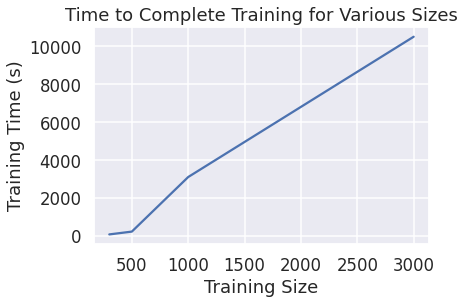

In [ ]:
plot_training_time([13, 14, 15])

#Sensitivity Analysis

In [4]:
from SALib import ProblemSpec

from SALib.analyze import sobol
from SALib.sample import saltelli
import seaborn as sns
import matplotlib.pyplot as plt

pred_columns = ["PM1", "PM2", "PM10", "CO", "CO2", "O3", "NO", "NO2"]

def perform_SA(trained_model):
  # get min and max of each column
  loc_interval = trained_model.dev_loc + "_" + trained_model.interval
  model_full_df = dfs[loc_interval][trained_model.date_range][trained_model.var_used]
  min_values = model_full_df.min()
  max_values = model_full_df.max()
  # Create a list of lists where each sublist contains the minimum and maximum value for each column
  bounds = [[min_values[i], max_values[i]] for i in range(len(min_values))]
  # define model inputs
  print(len(trained_model.var_used))
  print(trained_model.var_used.values)
  sp = ProblemSpec({
      'num_vars': len(trained_model.var_used),
      'names': trained_model.var_used.tolist(),
      'groups': None,
      'bounds': bounds,
      'outputs': pred_columns
  })
  sp.sample_sobol(1024)
  #construct dataframe
  df_gen = pd.DataFrame(data=sp.samples, columns=trained_model.var_used.tolist())
  new_model = trained_model.model.apply(df_gen)
  predictions = new_model.predict()
  print(len(predictions))
  sp.set_results(predictions[pred_columns].to_numpy())
  sp.analyze_sobol()
  print(sp)
  sp.heatmap()
  for pred_col in pred_columns:
    total_Si, first_Si, second_Si = sp.analysis[pred_col].to_df()
    print(second_Si.index)
    multi_index = pd.MultiIndex.from_tuples(second_Si.index.values, names=("Variable 1", "Variable 2"))
    second_Si = second_Si.set_index(multi_index)
    second_Si = second_Si.reset_index().pivot(columns='Variable 2', index='Variable 1', values='S2')
    firstAndTotal = pd.concat([total_Si["ST"], first_Si["S1"]], axis=1)
    plt.figure(figsize=(2.5, 6))
    plt.title(pred_col + " Total and First-Order Sensitivities")
    sns.heatmap(firstAndTotal, annot=True, cmap='coolwarm')
    plt.figure(figsize=(6,6))
    plt.title(pred_col + " Second-Order Sensitivities")
    sns.heatmap(second_Si, annot=False, square=True, cmap='coolwarm')


In [ ]:
model_4 = load_model(17)
perform_SA(model_4)

14
['CO' 'CO2' 'Humidity' 'NO' 'NO2' 'Noise' 'O3' 'PM1' 'PM10' 'PM2'
 'Pressure' 'Temperature' 'WindDirection' 'WindSpeed']


C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


MemoryError: ignored

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1014, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 2.20 GiB for an array with shape (98, 98, 30721) and data type float64


In [ ]:
# test between interval sizes
# indexeses for test
MODEL_IDXS = [1,2,3,4,5,6]
TEST_TITLE = ""
metrics_dfs = []
for i in MODEL_IDXS:
  trained_model = load_model(i)
  pred_df_dict = get_pred_df_dict(trained_model)
  metrics_df = get_metrics_df(pred_df_dict)
  metrics_dfs.append(metrics_df)

make_metrics_figures(metrics_dfs)



24


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



Forecast accuracy of PM1
mape   :  nan
me     :  nan
mae    :  nan
mpe    :  nan
rmse   :  nan
corr   :  nan
minmax :  nan

Forecast accuracy of PM2
mape   :  nan
me     :  nan
mae    :  nan
mpe    :  nan
rmse   :  nan
corr   :  nan
minmax :  nan

Forecast accuracy of PM10
mape   :  nan
me     :  nan
mae    :  nan
mpe    :  nan
rmse   :  nan
corr   :  nan
minmax :  nan

Forecast accuracy of CO
mape   :  nan
me     :  nan
mae    :  nan
mpe    :  nan
rmse   :  nan
corr   :  nan
minmax :  nan

Forecast accuracy of CO2
mape   :  nan
me     :  nan
mae    :  nan
mpe    :  nan
rmse   :  nan
corr   :  nan
minmax :  nan

Forecast accuracy of O3
mape   :  nan
me     :  nan
mae    :  nan
mpe    :  nan
rmse   :  nan
corr   :  nan
minmax :  nan

Forecast accuracy of NO
mape   :  nan
me     :  nan
mae    :  nan
mpe    :  nan
rmse   :  nan
corr   :  nan
minmax :  nan

Forecast accuracy of NO2
mape   :  nan
me     :  nan
mae    :  nan
mpe    :  nan
rmse   :  nan
corr   :  nan
minmax :  nan

Forecast 

<ipython-input-4-b7ae7c333cce>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-4-b7ae7c333cce>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


:  nan

Forecast accuracy of NO2
mape   :  nan
me     :  nan
mae    :  nan
mpe    :  nan
rmse   :  nan
corr   :  nan
minmax :  nan

Forecast accuracy of PM1
mape   :  nan
me     :  nan
mae    :  nan
mpe    :  nan
rmse   :  nan
corr   :  nan
minmax :  nan

Forecast accuracy of PM2
mape   :  nan
me     :  nan
mae    :  nan
mpe    :  nan
rmse   :  nan
corr   :  nan
minmax :  nan

Forecast accuracy of PM10
mape   :  nan
me     :  nan
mae    :  nan
mpe    :  nan
rmse   :  nan
corr   :  nan
minmax :  nan

Forecast accuracy of CO
mape   :  nan
me     :  nan
mae    :  nan
mpe    :  nan
rmse   :  nan
corr   :  nan
minmax :  nan

Forecast accuracy of CO2
mape   :  nan
me     :  nan
mae    :  nan
mpe    :  nan
rmse   :  nan
corr   :  nan
minmax :  nan

Forecast accuracy of O3
mape   :  nan
me     :  nan
mae    :  nan
mpe    :  nan
rmse   :  nan
corr   :  nan
minmax :  nan

Forecast accuracy of NO
mape   :  nan
me     :  nan
mae    :  nan
mpe    :  nan
rmse   :  nan
corr   :  nan
minmax :  nan

Fo

<ipython-input-4-b7ae7c333cce>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-4-b7ae7c333cce>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-4-b7ae7c333cce>:15: RuntimeWarning: divide by zero encountered in true_divide
  minmax = 1 - np.mean(mins/maxs)             # minmax


mape   :  20.5483
me     :  -9137.2379
mae    :  9785.0877
mpe    :  -19.2648
rmse   :  10848.7599
corr   :  0.8627
minmax :  20.0315

Forecast accuracy of O3
mape   :  2531.4809
me     :  -24469.34
mae    :  24469.34
mpe    :  -2531.4809
rmse   :  24908.0149
corr   :  -0.3209
minmax :  2531.4809

Forecast accuracy of NO
mape   :  339.208
me     :  5768.1603
mae    :  5768.1603
mpe    :  339.208
rmse   :  5898.3106
corr   :  0.6173
minmax :  0.9968

Forecast accuracy of NO2
mape   :  482.9824
me     :  -16738.8627
mae    :  16738.8627
mpe    :  -482.9824
rmse   :  17643.6791
corr   :  0.5703
minmax :  482.9824

Forecast accuracy of PM1
mape   :  inf
me     :  -4901.4225
mae    :  4901.4225
mpe    :  -inf
rmse   :  4958.0236
corr   :  nan
minmax :  nan

Forecast accuracy of PM2
mape   :  inf
me     :  -7056.0914
mae    :  7056.0914
mpe    :  -inf
rmse   :  7129.8009
corr   :  nan
minmax :  nan

Forecast accuracy of PM10
mape   :  inf
me     :  -9426.9111
mae    :  9426.9111
mpe    :  -i

<ipython-input-4-b7ae7c333cce>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-4-b7ae7c333cce>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)



rmse   :  1370.0811
corr   :  nan
minmax :  nan

Forecast accuracy of NO
mape   :  29.6939
me     :  -445.7854
mae    :  445.7973
mpe    :  -29.6931
rmse   :  453.4369
corr   :  nan
minmax :  nan

Forecast accuracy of NO2
mape   :  96.7781
me     :  -1462.1444
mae    :  1462.1444
mpe    :  -96.7781
rmse   :  1465.2436
corr   :  nan
minmax :  nan

Forecast accuracy of PM1
mape   :  inf
me     :  -282.8761
mae    :  283.236
mpe    :  -inf
rmse   :  295.8604
corr   :  nan
minmax :  nan

Forecast accuracy of PM2
mape   :  inf
me     :  -289.7221
mae    :  292.1486
mpe    :  -inf
rmse   :  307.8942
corr   :  nan
minmax :  nan

Forecast accuracy of PM10
mape   :  inf
me     :  -299.0581
mae    :  301.6004
mpe    :  -inf
rmse   :  317.8348
corr   :  nan
minmax :  nan

Forecast accuracy of CO
mape   :  36.5443
me     :  -9174.9694
mae    :  9174.9694
mpe    :  -36.5443
rmse   :  9199.5932
corr   :  nan
minmax :  nan

Forecast accuracy of CO2
mape   :  4.8583
me     :  -2202.7778
mae    :  220

<ipython-input-4-b7ae7c333cce>:15: RuntimeWarning: divide by zero encountered in true_divide
  minmax = 1 - np.mean(mins/maxs)             # minmax


37.3862
me     :  -9637.9794
mae    :  9637.9794
mpe    :  -37.3862
rmse   :  9671.6501
corr   :  nan
minmax :  nan

Forecast accuracy of CO2
mape   :  5.2438
me     :  -2379.8459
mae    :  2379.8459
mpe    :  -5.2438
rmse   :  2395.8705
corr   :  nan
minmax :  nan

Forecast accuracy of O3
mape   :  53.4057
me     :  1488.5938
mae    :  1488.5938
mpe    :  53.4057
rmse   :  1502.6674
corr   :  nan
minmax :  nan

Forecast accuracy of NO
mape   :  32.7036
me     :  -504.7826
mae    :  504.7856
mpe    :  -32.7034
rmse   :  512.4897
corr   :  nan
minmax :  nan

Forecast accuracy of NO2
mape   :  93.2978
me     :  -1463.7824
mae    :  1463.7824
mpe    :  -93.2978
rmse   :  1464.7652
corr   :  nan
minmax :  nan
96

Forecast accuracy of PM1
mape   :  2174.032
me     :  3408.7928
mae    :  3408.7928
mpe    :  2174.032
rmse   :  3471.4335
corr   :  -0.3191
minmax :  0.9992

Forecast accuracy of PM2
mape   :  2014.9732
me     :  3990.3257
mae    :  3990.3257
mpe    :  2014.9732
rmse   :  4051.97

<ipython-input-4-b7ae7c333cce>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-4-b7ae7c333cce>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


mape   :  inf
me     :  4378.049
mae    :  4378.049
mpe    :  inf
rmse   :  4383.4865
corr   :  0.1198
minmax :  0.9983

Forecast accuracy of PM10
mape   :  inf
me     :  5494.636
mae    :  5494.636
mpe    :  inf
rmse   :  5501.0311
corr   :  0.1201
minmax :  0.9982

Forecast accuracy of CO
mape   :  525.1496
me     :  -154518.2885
mae    :  154518.2885
mpe    :  -525.1496
rmse   :  154825.8357
corr   :  -0.0291
minmax :  525.1496

Forecast accuracy of CO2
mape   :  31.771
me     :  -14701.7894
mae    :  14718.6889
mpe    :  -31.734
rmse   :  14779.1192
corr   :  -0.073
minmax :  31.7563

Forecast accuracy of O3
mape   :  3593.1588
me     :  33750.8765
mae    :  33750.8765
mpe    :  3593.1588
rmse   :  33917.149
corr   :  -0.0706
minmax :  0.9991

Forecast accuracy of NO
mape   :  1792.8086
me     :  -27243.6808
mae    :  27243.6808
mpe    :  -1792.8086
rmse   :  27307.1009
corr   :  -0.0649
minmax :  1792.8086

Forecast accuracy of NO2
mape   :  803.9264
me     :  -26693.6965
mae    :

<ipython-input-4-b7ae7c333cce>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-4-b7ae7c333cce>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


mape   :  289.7658
me     :  9553.6573
mae    :  9553.6573
mpe    :  289.7658
rmse   :  9555.9404
corr   :  nan
minmax :  nan

Forecast accuracy of NO
mape   :  165.4748
me     :  -2633.3689
mae    :  2633.3689
mpe    :  -165.4748
rmse   :  2634.4739
corr   :  nan
minmax :  nan

Forecast accuracy of NO2
mape   :  158.7505
me     :  2617.8837
mae    :  2618.6926
mpe    :  158.7172
rmse   :  2620.4477
corr   :  nan
minmax :  nan

Forecast accuracy of PM1
mape   :  inf
me     :  1304.2429
mae    :  1304.3419
mpe    :  inf
rmse   :  1304.8844
corr   :  nan
minmax :  nan

Forecast accuracy of PM2
mape   :  inf
me     :  1702.4733
mae    :  1702.5485
mpe    :  inf
rmse   :  1703.2559
corr   :  nan
minmax :  nan

Forecast accuracy of PM10
mape   :  inf
me     :  1766.4225
mae    :  1766.4925
mpe    :  inf
rmse   :  1767.243
corr   :  nan
minmax :  nan

Forecast accuracy of CO
mape   :  37.0421
me     :  9423.9321
mae    :  9440.1
mpe    :  36.9803
rmse   :  9443.3797
corr   :  nan
minmax :  n

<ipython-input-4-b7ae7c333cce>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-4-b7ae7c333cce>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


mape   :  177.7796
me     :  52931.9145
mae    :  52931.9145
mpe    :  177.7796
rmse   :  52992.3655
corr   :  -0.1587
minmax :  0.9938

Forecast accuracy of CO2
mape   :  37.8205
me     :  17652.6531
mae    :  17652.6531
mpe    :  37.8205
rmse   :  17655.328
corr   :  -0.0441
minmax :  0.9742

Forecast accuracy of O3
mape   :  130.4204
me     :  1960.1089
mae    :  1960.1089
mpe    :  130.4204
rmse   :  1981.8482
corr   :  0.1149
minmax :  0.9862

Forecast accuracy of NO
mape   :  482.9872
me     :  -7219.3921
mae    :  7219.3921
mpe    :  -482.9872
rmse   :  7222.8404
corr   :  0.1217
minmax :  482.9872

Forecast accuracy of NO2
mape   :  453.9197
me     :  14428.3502
mae    :  14428.3502
mpe    :  453.9197
rmse   :  14439.6674
corr   :  -0.07
minmax :  0.9975

Forecast accuracy of PM1
mape   :  inf
me     :  2198.0481
mae    :  2198.0481
mpe    :  inf
rmse   :  2199.7384
corr   :  -0.0439
minmax :  0.9981

Forecast accuracy of PM2
mape   :  inf
me     :  2767.2207
mae    :  2767.220

AttributeError: ignored

Error in callback <function flush_figures at 0x7fa21855c820> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
print(metrics_dfs[0][('PM1', 'mape')])

day        NaN
week       NaN
2_weeks    NaN
month      NaN
Name: (PM1, mape), dtype: object


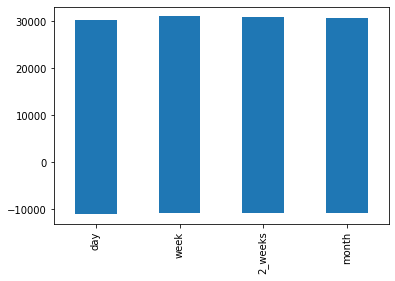

In [ ]:
for metrics in metrics_dfs:
  for col in metrics.columns:
    metrics[col].plot(kind='bar')


In [ ]:
min_interval = 60 #change depending on data interval
n_day_forecast = int(1440 / min_interval)
print(n_day_forecast)
n_week_forecast = int(n_day_forecast*7)
n_2week_forecast = int(n_week_forecast*2)
n_month_forecast = int(n_2week_forecast*2)
predict_day = fitted_model.get_prediction(start=len(train_df), end=len(train_df) + n_day_forecast - 1)
predict_week = fitted_model.get_prediction(start=len(train_df), end=len(train_df) + n_week_forecast - 1)
predict_2week = fitted_model.get_prediction(start=len(train_df), end=len(train_df) + n_2week_forecast - 1)
predict_month = fitted_model.get_prediction(start=len(train_df), end=len(train_df) + n_month_forecast - 1)

predictions_day=predict_day.predicted_mean.add_suffix('_Prediction')
predictions_week=predict_week.predicted_mean.add_suffix('_Prediction')
predictions_2week=predict_2week.predicted_mean.add_suffix('_Prediction')
predictions_month=predict_month.predicted_mean.add_suffix('_Prediction')

In [ ]:
valid_vs_pred_day_df = pd.concat([valid_df.iloc[:n_day_forecast], predictions_day], axis=1)
valid_vs_pred_week_df = pd.concat([valid_df.iloc[:n_week_forecast], predictions_week], axis=1)
valid_vs_pred_2week_df = pd.concat([valid_df.iloc[:n_2week_forecast], predictions_2week], axis=1)
valid_vs_pred_month_df = pd.concat([valid_df.iloc[:n_month_forecast], predictions_month], axis=1)